# Objectron Geometry Tutorial

This notebook shows how to parse the geometry.pbdata for each sequence. Geometry.pbdata contains the AR Metadata information for each sequence. 

In [1]:
import numpy as np
import os
import requests
import struct
import sys
import subprocess
import cv2

from IPython.core.display import display,HTML
import matplotlib.pyplot as plt

# I'm running this Jupyter notebook locally. Manually import the objectron module.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The AR Metadata captured with each frame in the video
from objectron.schema import a_r_capture_metadata_pb2 as ar_metadata_protocol
# The annotations are stored in protocol buffer format. 
from objectron.schema import object_pb2 as object_protocol
from objectron.schema import annotation_data_pb2 as annotation_protocol
import objectron.dataset.box as Box

/tmp/ipykernel_229/3918948755.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display,HTML


First, let's download a video and corresponding metadata from the Objectron bucket. The bucket allows public (unauthenticated) http access, so we can directly download the file from the bucket.

In [2]:
public_url = "https://storage.googleapis.com/objectron"
blob_path = public_url + "/v1/index/shoe_annotations_train"
video_ids = requests.get(blob_path).text
video_ids = video_ids.split('\n')
print(len(video_ids))

1694


In [3]:
# Download the first ten videos in cup test dataset
for i in range(1):
    video_filename = public_url + "/videos/" + video_ids[i] + "/video.MOV"
    metadata_filename = public_url + "/videos/" + video_ids[i] + "/geometry.pbdata"
    annotation_filename = public_url + "/annotations/" + video_ids[i] + ".pbdata"
    # video.content contains the video file.
    video = requests.get(video_filename)
    metadata = requests.get(metadata_filename)
    
    # Please refer to Parse Annotation tutorial to see how to parse the annotation files.
    annotation = requests.get(annotation_filename)
    
    file = open("video.MOV", "wb")
    file.write(video.content)
    file.close()
    
    file = open("geometry.pbdata", "wb")
    file.write(metadata.content)
    file.close()
    
    file = open("annotation.pbdata", "wb")
    file.write(annotation.content)
    file.close()

!ls

 3D_IOU.ipynb			   'Parse Annotations.ipynb'
'Download Data.ipynb'		    annotation.pbdata
'Hello World.ipynb'		    geometry.pbdata
 Objectron_NeRF_Tutorial.ipynb	    objectron-geometry-tutorial.ipynb
 Objectron_Pytorch_tutorial.ipynb   video.MOV


## Parsing geometry.pbdata

The geometry.pbdata is slightly unconventional, as it is packed with a series of a_r_capture_metadata, for each frame in the video. For each a_r_capture_metadata is preceeded by four-bytes that specify the length of the message.

We can grab different fields from teh frame_data. For the list of available fields and their desription see the [a_r_capture_metadata.proto](https://github.com/google-research-datasets/Objectron/blob/master/objectron/schema/a_r_capture_metadata.proto)

Here we care about the `ARFrame` message and the fields there in. Specifically, the `camera` contains the information about the camera pose, the `plane_anchor` contains planes information in the scene and `raw_feature_points` contains the 3D point cloud used by the AR tracking system. 

In [4]:
def get_geometry_data(geometry_filename):
    sequence_geometry = []
    with open(geometry_filename, 'rb') as pb:
        proto_buf = pb.read()

        i = 0
        frame_number = 0

        while i < len(proto_buf):
            # Read the first four Bytes in little endian '<' integers 'I' format
            # indicating the length of the current message.
            msg_len = struct.unpack('<I', proto_buf[i:i + 4])[0]
            i += 4
            message_buf = proto_buf[i:i + msg_len]
            i += msg_len
            frame_data = ar_metadata_protocol.ARFrame()
            frame_data.ParseFromString(message_buf)


            transform = np.reshape(frame_data.camera.transform, (4, 4))
            projection = np.reshape(frame_data.camera.projection_matrix , (4, 4))
            view = np.reshape(frame_data.camera.view_matrix , (4, 4))
            position = transform[:3, -1]

            current_points = [np.array([v.x, v.y, v.z])
                              for v in frame_data.raw_feature_points.point]
            current_points = np.array(current_points)

            sequence_geometry.append((transform, projection, view, current_points))
    return sequence_geometry

Similarly we can parse the annotation protos as well. The annotation protos also contains a copy of the ARCamera message too, which will be used to projects the 3D Bounding box to the image plane. For projecting the points from 3D to 2D, you can either 1) transform * extrinsics, or use 2) projection * view. Approach 1 is popular in 3D geometry community, while 2) is used often by computer graphics folks. For more details see this [OpenGL tutorial](http://www.songho.ca/opengl/gl_camera.html).

In [5]:
def get_frame_annotation(annotation_filename):
    """Grab an annotated frame from the sequence."""
    result = []
    instances = []
    with open(annotation_filename, 'rb') as pb:
        sequence = annotation_protocol.Sequence()
        sequence.ParseFromString(pb.read())

        object_id = 0
        object_rotations = []
        object_translations = []
        object_scale = []
        num_keypoints_per_object = []
        object_categories = []
        annotation_types = []
        
        # Object instances in the world coordinate system, These are stored per sequence, 
        # To get the per-frame version, grab the transformed keypoints from each frame_annotation
        for obj in sequence.objects:
            rotation = np.array(obj.rotation).reshape(3, 3)
            translation = np.array(obj.translation)
            scale = np.array(obj.scale)
            points3d = np.array([[kp.x, kp.y, kp.z] for kp in obj.keypoints])
            instances.append((rotation, translation, scale, points3d))
        
        # Grab teh annotation results per frame
        for data in sequence.frame_annotations:
            # Get the camera for the current frame. We will use the camera to bring
            # the object from the world coordinate to the current camera coordinate.
            transform = np.array(data.camera.transform).reshape(4, 4)
            view = np.array(data.camera.view_matrix).reshape(4, 4)
            intrinsics = np.array(data.camera.intrinsics).reshape(3, 3)
            projection = np.array(data.camera.projection_matrix).reshape(4, 4)
        
            keypoint_size_list = []
            object_keypoints_2d = []
            object_keypoints_3d = []
            for annotations in data.annotations:
                num_keypoints = len(annotations.keypoints)
                keypoint_size_list.append(num_keypoints)
                for keypoint_id in range(num_keypoints):
                    keypoint = annotations.keypoints[keypoint_id]
                    object_keypoints_2d.append((keypoint.point_2d.x, keypoint.point_2d.y, keypoint.point_2d.depth))
                    object_keypoints_3d.append((keypoint.point_3d.x, keypoint.point_3d.y, keypoint.point_3d.z))
                num_keypoints_per_object.append(num_keypoints)
                object_id += 1
            result.append((object_keypoints_2d, object_keypoints_3d, keypoint_size_list, view, projection))

    return result, instances

This is a helper function to extract a few image frames from the video file using ffmpeg utility.

In [6]:
def grab_frame(video_file, frame_ids):
  """Grab an image frame from the video file."""
  frames = []
  capture = cv2.VideoCapture(video_file)
  height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
  fps = int(capture.get(cv2.CAP_PROP_FPS))
  print(height, width ,fps)
  capture.release()
  frame_size = width * height * 3

  for frame_id in frame_ids:
    frame_filter = r'select=\'eq(n\,{:d})\''.format(frame_id)
    command = [
        'ffmpeg', '-i', video_file, '-f', 'image2pipe', '-vf', frame_filter,
        '-pix_fmt', 'rgb24', '-vcodec', 'rawvideo', '-vsync', 'vfr', '-'
    ]
    pipe = subprocess.Popen(
        command, stdout=subprocess.PIPE, bufsize = 151 * frame_size)
    current_frame = np.frombuffer(
        pipe.stdout.read(frame_size), dtype='uint8').reshape(height, width, 3)
    pipe.stdout.flush()

    frames.append(current_frame)
  return frames

# Projecting Points from 3D to 2D

We go over the sequence and for a few frames:
1. Compute the 3D bounding box (vertices in 3D)
2. Project those points to image using the camera information
3. Project the scene point-cloud to the image plane

In [7]:
def project_points(points, projection_matrix, view_matrix, width, height):
    p_3d = np.concatenate((points, np.ones_like(points[:, :1])), axis=-1).T
    p_3d_cam = np.matmul(view_matrix, p_3d)
    p_2d_proj = np.matmul(projection_matrix, p_3d_cam)
    # Project the points
    p_2d_ndc = p_2d_proj[:-1, :] / p_2d_proj[-1, :]
    p_2d_ndc = p_2d_ndc.T

    # Convert the 2D Projected points from the normalized device coordinates to pixel values
    x = p_2d_ndc[:, 1]
    y = p_2d_ndc[:, 0]
    pixels = np.copy(p_2d_ndc)
    pixels[:, 0] = ((1 + x) * 0.5) * width
    pixels[:, 1] = ((1 + y) * 0.5) * height    
    pixels = pixels.astype(int)
    return pixels

1920 1440 30


ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

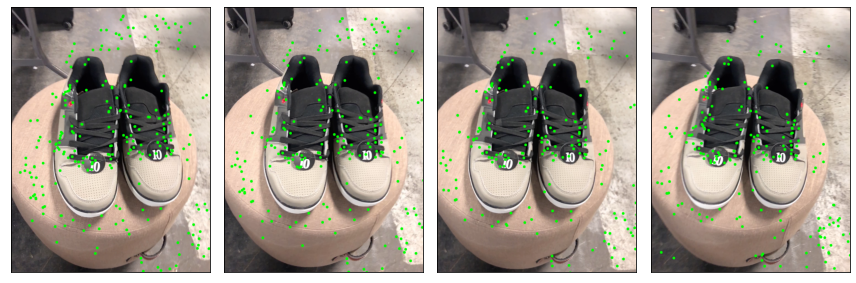

In [8]:
# Grab some frames from the video file.
frame_ids = [100, 105, 110, 115]
num_frames = len(frame_ids)
sequence_geometry = get_geometry_data('geometry.pbdata')
frames = grab_frame('video.MOV', frame_ids)
annotation_data, instances = get_frame_annotation('annotation.pbdata')
fig, ax = plt.subplots(1, num_frames, figsize = (12, 16))

for i in range(len(frame_ids)):
    frame_id = frame_ids[i]    
    image = frames[i]
    height, width, _ = image.shape
    points_2d, points_3d, num_keypoints, frame_view_matrix, frame_projection_matrix = annotation_data[frame_id]
    num_instances = len(num_keypoints)
    
    
    # # As covered in our previous tutorial, we can directly grab the 2D projected points from the annotation
    # # file. The projections are normalized, so we scale them with the image's height and width to get 
    # # the pixel value.
    # # The keypoints are [x, y, d] where `x` and `y` are normalized (`uv`-system)\
    # # and `d` is the metric distance from the center of the camera. Convert them
    # # keypoint's `xy` value to pixel.
    # points_2d = np.split(points_2d, np.array(np.cumsum(num_keypoints)))    
    # points_2d = [points.reshape(-1, 3) for points in points_2d]
    # points_2d = [
    #     np.multiply(keypoint, np.asarray([width, height, 1.], np.float32)).astype(int)
    #     for keypoint in points_2d
    # ]
    
    # points_2d = []
    # # Now, let's compute the box's vertices in 3D, then project them back to 2D:
    # for instance_id in range(num_instances):
    #     # The annotation contains the box's transformation and scale in world coordinate system
    #     # Here the instance_vertices_3d are the box vertices in the "BOX" coordinate, (i.e. it's a unit box)
    #     # and has to be transformed to the world coordinate.
    #     instance_rotation, instance_translation, instance_scale, instance_vertices_3d = instances[instance_id]
        
    #     box_transformation = np.eye(4)
    #     box_transformation[:3, :3] = np.reshape(instance_rotation, (3, 3))
    #     box_transformation[:3, -1] = instance_translation
    #     vertices_3d = instance_vertices_3d * instance_scale.T;
    #     # Homogenize the points
    #     vertices_3d_homg = np.concatenate((vertices_3d, np.ones_like(vertices_3d[:, :1])), axis=-1).T
    #     # Transform the homogenious 3D vertices with the box transformation
    #     box_vertices_3d_world = np.matmul(box_transformation, vertices_3d_homg) 
        
    #     # If we transform these vertices to the camera frame, we get the 3D keypoints in the annotation data
    #     # i.e. vertices_3d_cam == points_3d
    #     vertices_3d_cam = np.matmul(frame_view_matrix, box_vertices_3d_world)
    #     vertices_2d_proj = np.matmul(frame_projection_matrix, vertices_3d_cam)
        
    #     # Project the points
    #     points2d_ndc = vertices_2d_proj[:-1, :] / vertices_2d_proj[-1, :]
    #     points2d_ndc = points2d_ndc.T
        
    #     # Convert the 2D Projected points from the normalized device coordinates to pixel values
    #     x = points2d_ndc[:, 1]
    #     y = points2d_ndc[:, 0]
    #     points2d = np.copy(points2d_ndc)
    #     points2d[:, 0] = ((1 + x) * 0.5) * width
    #     points2d[:, 1] = ((1 + y) * 0.5) * height    
    #     points_2d.append(points2d.astype(int))
    #     # points2d are the projected 3D points on the image plane.
        
    # # Visualize the boxes
    # for instance_id in range(num_instances):
    #     for kp_id in range(num_keypoints[instance_id]):
    #       kp_pixel = points_2d[instance_id][kp_id, :]
    #       cv2.circle(image, (kp_pixel[0], kp_pixel[1]), 10, (255, 0, 0), -1)
    #     for edge in Box.EDGES:
    #         start_kp = points_2d[instance_id][edge[0], :]
    #         end_kp = points_2d[instance_id][edge[1], :]
    #         cv2.line(image, (start_kp[0], start_kp[1]), (end_kp[0], end_kp[1]), (255, 0, 0), 2)
        
    # We can also use the above pipeline to visualize the scene point-cloud on the image.
    # First, let's grab the point-cloud from the geometry metadata
    transform, projection, view, scene_points_3d = sequence_geometry[frame_id]
    scene_points_2d = project_points(scene_points_3d, projection, view, width, height)
    # Note these points all have estimated depth, which can double as a sparse depth map for the image.
    
    for point_id in range(scene_points_2d.shape[0]):
       cv2.circle(image, (scene_points_2d[point_id, 0], scene_points_2d[point_id, 1]), 10,
                      (0, 255, 0), -1)
    ax[i].grid(False)
    ax[i].imshow(image);
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
        
fig.tight_layout();
plt.show()


We can directly visualize the 3D point cloud in the world coordinate system. 
The world coodinate system assumes +y is always up. Note these are points used by the tracking systems, so they are 
highly concentrated around the high-gradient parts of the image and are not necessary uniformly distributed.

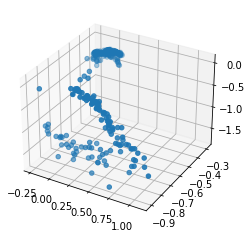

In [9]:
frame_id = 100
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
transform, projection, view, points_3d = sequence_geometry[frame_id]
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2])